In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime as dt
from pandas_datareader import DataReader as DR
import seaborn as sb
import numdifftools as nd
from wquantiles import quantile
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF

from scipy.stats import norm,t,truncnorm
from scipy.stats import multivariate_normal as mvnorm
from scipy.stats import multivariate_t as mvt
from scipy.spatial import Delaunay as TRI
from scipy.interpolate import LinearNDInterpolator as ITP
from scipy.optimize import minimize,root
from scipy.optimize import NonlinearConstraint as NonlinCons
from scipy.stats import gaussian_kde as sciKDE

from sklearn.linear_model import LinearRegression as Linear
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.neighbors import KernelDensity as sklKDE

import warnings
warnings.filterwarnings("ignore")

# Define the experiment class

In [2]:
class MLE:
    def __init__(self,dim,alpha,sigma,size,df=1):
        self.alpha=alpha
        self.VaR=norm.ppf(alpha)
        aVar=np.array([alpha*(1-alpha),4*(alpha*(1-alpha))**2])/norm.pdf(self.VaR)**2
        aErr=np.sqrt(aVar/size)
        print('Reference for a-var & a-err (direct, optimal): {} & {}'.format(np.round(aVar,4),np.round(aErr,4)))
        
        self.dim=dim
        self.T=lambda x: mvnorm.pdf(x=x,mean=np.zeros(dim))
        self.oP=lambda x,VaR: self.T(x)*np.abs(1.0*(x[:,0]<VaR)-self.alpha)/(2*self.alpha*(1-self.alpha))
        self.iP=lambda x: mvt.pdf(x=x,loc=np.zeros(dim),shape=sigma**2,df=df)
        self.iS=lambda size: mvt.rvs(size=size,loc=np.zeros(dim),shape=sigma**2,df=df)
        self.size=size
        
    def __estimate(self,S,W,name,asym=True):
        self.eVaR=quantile(S[:,0],W,self.alpha)
        err=self.eVaR-self.VaR
        if asym:
            w=W/np.sum(W)
            aVar=np.sum((w*(1.0*(S[:,0]<=self.eVaR)-self.alpha))**2)*W.size
            aVar/=norm.pdf(self.VaR)**2
            aErr=np.sqrt(aVar/W.size)
            ESS=1/np.sum(w**2)
            
            Wf=W*(S[:,0]<self.eVaR)
            wf=Wf/np.sum(Wf)
            ESSf=1/np.sum(wf**2)
            print('{} est: {:.4f}; err: {:.4f}; a-var: {:.4f}; a-err: {:.4f}; ESS: {:.0f}/{}; ESS(f): {:.0f}/{}'\
                  .format(name,self.eVaR,err,aVar,aErr,ESS,W.size,ESSf,W.size))
        else:
            print('{} est: {:.4f}; err: {:.4f}'.format(name,self.eVaR,err))
            
        if any(W<0):
            W[W<0]=0
            self.eVaR=quantile(S[:,0],W,self.alpha)
            err=self.eVaR-self.VaR
            print('(adjusted) {} est: {:.4f}; err: {:.4f}'.format(name,self.eVaR,err))
        
    def estimate_IS(self):
        S=self.iS(self.size)
        W=self.T(S)/self.iP(S)
        self.__estimate(S,W,'IS')
    
    def draw_TP(self,P,x,name,dim=0):
        X=np.zeros([x.size,self.dim])
        X[:,dim]=x
        fig,ax=plt.subplots(figsize=(7,4))
        ax.plot(x,self.T(X))
        ax.plot(x,self.oP(X,self.VaR))
        ax.plot(x,P(X))
        if name=='nonparametric':
            one=np.zeros(self.dim)
            one[dim]=1
            rW=np.array([self.h(one*loc,loc) for loc in self.rS])
            rW=rW/rW.max()*P(X).max()
            rWmeans=np.ones_like(rW)*rW.mean()

            ax.plot(x,self.mP(X))
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rWmeans)
            ax.hist(self.rS[:,dim],bins=2*rW.size,weights=rW)
            ax.legend(['target','optimal proposal','nonparametric proposal',\
                       'mixture proposal','centers','centers with weight'])
        else:
            ax.legend(['target','optimal proposal','{} proposal'.format(name)])
            
        ax.set_title('{}-D target and {} proposal (cross-sectional view)'.format(self.dim,name))
        plt.show()
        
    def resample(self,size,ratio):
        S=self.iS(ratio*size)
        p=self.oP(S,self.eVaR)/self.iP(S)
        index=np.arange(S.shape[0])
        choice=np.random.choice(index,size,p=p/np.sum(p),replace=True)
        
        self.rS=S[choice]
        self.rSset=S[list(set(choice))]
        print('resampling rate: {}/{}'.format(self.rSset.shape[0],size))
        
    def estimate_NIS(self,rate,bdwth='scott'):
        self.kde=sciKDE(self.rS.T,bw_method=bdwth)
        cov=self.kde.covariance_factor()*np.cov(self.rS.T)
        print('bdwth: {}'.format(np.round(np.sqrt(np.diag(cov)),2)))
        self.h=lambda x,loc: mvnorm.pdf(x=x,mean=loc,cov=cov)
        def G(x):
            tmp=np.array([self.h(x,loc) for loc in self.rSset])
            return tmp[1:]-tmp.mean(axis=0)

        self.G=G
        
        self.nP=lambda x: self.kde.pdf(x.T)
        self.nS=lambda size: self.kde.resample(size).T
        S=self.nS(self.size)
        W=self.T(S)/self.nP(S)
        self.__estimate(S,W,'NIS')
        
        self.mP=lambda x: (1-rate)*self.iP(x)+rate*self.nP(x)
        self.mS=lambda size: np.vstack([self.iS(size-round(rate*size)),self.nS(round(rate*size))])
        self.S=self.mS(self.size)
        W=self.T(self.S)/self.mP(self.S)
        self.__estimate(self.S,W,'MIS')
    
    def estimate_RIS_MLE(self,opt=True,NR=True):
        mP=self.mP(self.S)
        G=self.G(self.S)
        target=lambda zeta: -np.mean(np.log(mP+zeta.dot(G)))
        gradient=lambda zeta: -np.mean(G/(mP+zeta.dot(G)),axis=1)
        hessian=lambda zeta: (G/(mP+zeta.dot(G))**2).dot(G.T)/G.shape[1]
        zeta0=np.zeros(G.shape[0])
        grad0=gradient(zeta0)
        print('Reference:')
        print('origin: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta0),grad0.min(),grad0.mean(),grad0.max(),grad0.std()))
        
        print()
        print('Theoretical results:')
        X=(G/mP).T
        XX=X-X.mean(axis=0)
        zeta1=np.linalg.solve(XX.T.dot(XX),X.sum(axis=0))
        print('MLE(The) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
              .format(zeta1.min(),zeta1.mean(),zeta1.max(),zeta1.std(),np.sqrt(np.sum(zeta1**2))))
        grad1=gradient(zeta1)
        print('theory: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
              .format(target(zeta1),grad1.min(),grad1.mean(),grad1.max(),grad1.std()))
        W=(self.T(self.S)/mP)*(1-XX.dot(zeta1))
        print('reg weights: (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
              .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
        self.__estimate(self.S,W,'RIS',asym=False)
        W=self.T(self.S)/(mP+zeta1.dot(G))
        print('mle weights (The): (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
              .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
        self.__estimate(self.S,W,'MLE(The)',asym=False)
        
        if opt:
            zeta=zeta1 if target(zeta1)!=np.nan else zeta0
            begin=dt.now()
            if NR:
                res=root(lambda zeta: (gradient(zeta),hessian(zeta)),zeta,method='lm',jac=True)
            else:
                cons=({'type':'ineq','fun':lambda zeta: mP+zeta.dot(G),'jac':lambda zeta: G.T})
                res=minimize(target,zeta,method='SLSQP',jac=gradient,constraints=cons,\
                             options={'ftol':1e-8,'maxiter':1000})
            
            end=dt.now()
            print()
            print('Optimization results (spent {} seconds):'.format((end-begin).seconds))
            if res['success']:
                zeta=res['x']
                print('MLE(Opt) zeta: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f}, norm {:.4f})'\
                      .format(zeta.min(),zeta.mean(),zeta.max(),zeta.std(),np.sqrt(np.sum(zeta**2))))
                print('Dist(zeta(Opt),zeta(The))={:.4f}'.format(np.sqrt(np.sum((zeta-zeta1)**2))))
                grad=gradient(zeta)
                print('optimal: value: {:.4f}; grad: (min {:.4f}, mean {:.4f}, max {:.4f}, std {:.4f})'\
                      .format(target(zeta),grad.min(),grad.mean(),grad.max(),grad.std()))
                W=self.T(self.S)/(mP+zeta.dot(G))
                print('mle weights (Opt): (min {:.4f}, mean {:.4f}, max {:.4f}, [<0] {}/{})'\
                      .format(W.min(),W.mean(),W.max(),np.sum(W<0),W.size))
                self.__estimate(self.S,W,'MLE(Opt)',asym=False)
            else:
                print('MLE fail')

Reference for a-var & a-err (direct, optimal): [4.4656 0.8485] & [0.0067 0.0029]
IS est: -1.6452; err: -0.0003; a-var: 12.5016; a-err: 0.0112; ESS: 21898/100000; ESS(f): 1851/100000


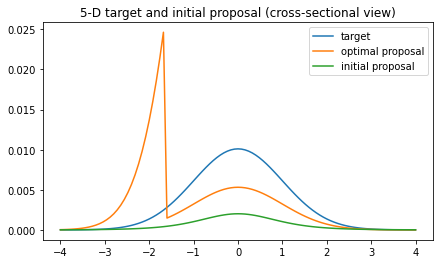

resampling rate: 935/1000
bdwth: [0.87 0.71 0.68 0.68 0.7 ]
NIS est: -1.6530; err: -0.0081; a-var: 1.5548; a-err: 0.0039; ESS: 42799/100000; ESS(f): 21033/100000
MIS est: -1.6447; err: 0.0002; a-var: 1.5570; a-err: 0.0039; ESS: 44129/100000; ESS(f): 20649/100000


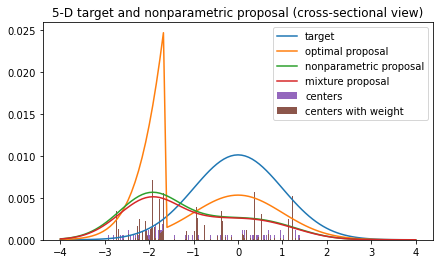

Reference:
origin: value: 8.5728; grad: (min -0.2394, mean 0.0000, max 0.1777, std 0.0320)

Theoretical results:
MLE(The) zeta: (min -0.0557, mean 0.0014, max 0.0659, std 0.0073, norm 0.2280)
theory: value: nan; grad: (min -2.4500, mean -0.0000, max 0.4289, std 0.0949)
reg weights: (min -0.0883, mean 0.9973, max 11.3578, [<0] 11/100000)
RIS est: -1.6465; err: -0.0017
(adjusted) RIS est: -1.6465; err: -0.0017
mle weights (The): (min -77.0012, mean 0.9986, max 139.8182, [<0] 23/100000)
MLE(The) est: -1.6444; err: 0.0004
(adjusted) MLE(The) est: -1.6448; err: 0.0001

Optimization results (spent 27 seconds):
MLE(Opt) zeta: (min -0.0562, mean 0.0014, max 0.0668, std 0.0077, norm 0.2404)
Dist(zeta(Opt),zeta(The))=0.0718
optimal: value: nan; grad: (min -0.0000, mean 0.0000, max 0.0000, std 0.0000)
mle weights (Opt): (min -10.4571, mean 0.9999, max 14.5351, [<0] 23/100000)
MLE(Opt) est: -1.6461; err: -0.0012
(adjusted) MLE(Opt) est: -1.6462; err: -0.0014


In [3]:
mle=MLE(dim=5,alpha=0.05,sigma=2,size=100000,df=1)
mle.estimate_IS()
x=np.linspace(-4,4,101)
mle.draw_TP(mle.iP,x,'initial')
print('=======================================================')
mle.resample(1000,100)
mle.estimate_NIS(0.9)
mle.draw_TP(mle.nP,x,'nonparametric')
print('=======================================================')
mle.estimate_RIS_MLE()

In [48]:
np.interp(15,[10,2,1,0,20],[-2,0,40,4,50])

38.5

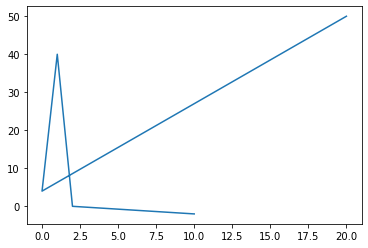

In [49]:
plt.plot([10,2,1,0,20],[-2,0,40,4,50])